# Title
### Time Series Forecasting

# Business Understanding
### Introduction


This project focuses on time series forecasting to predict store sales for Corporation Favorita, a large Ecuadorian-based grocery retailer. The objective is to build a model that accurately predicts the unit sales for thousands of items sold at different Favorita stores

## Hypothesis
 
 Null Hypothesis: The type of holiday does not have any significant on the increase of sales
 
 Alternative Hypothesis: The type of holiday has significant impact on the increase in sales
 
 ## Questions

The questions below are to be answered. Do note that, you are free to draw more hypothesis from the data.

1. Is the train dataset complete (has all the required dates)?

2. Which dates have the lowest and highest sales for each year?

3. Did the earthquake impact sales?

4. Are certain groups of stores selling more products? (Cluster, city, state, type)

5. Are sales affected by promotions, oil prices and holidays?

6. What analysis can we get from the date and its extractable features?

7. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

Your task is to build a model that more accurately predicts the unit sales for thousands of items.

# Importing Liberaries

In [ ]:
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot  as plt 
import seaborn as sns
import matplotlib.dates as mdates
import plotly.express as px

# impoerting and reading sql file
import pyodbc
from dotenv import dotenv_values



# Statistical Analysis
from statsmodels.tsa.stattools import adfuller
from scipy.stats import ttest_ind
import scipy.stats as stats
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error


# Feature processing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Modelling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import RandomizedSearchCV
import pickle


# cancelling warning messages
import warnings
warnings.filterwarnings("ignore")



#### Loading the data set from SQL server

In [ ]:
# # create dotenv environment
# environment_variables = dotenv_values()

# # get varriable from .env created
# server = environment_variables.get("SERVER")
# database = environment_variables.get("DATABASE")
# username = environment_variables.get("USERNAME")
# password =environment_variables.get("PASSWORD")




In [3]:
# create  connections to the server using sever name, username, database and password
# conn_str = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [4]:
# Use the connect method of the pyodbc library and pass in the connection string.
# This will connect to the server 


# connection = pyodbc.connect(conn_str)

In [5]:
# # read data from oil table
# query = "SELECT * From dbo.oil"
# oil_df = pd.read_sql(query,connection, parse_dates=["date"])

# # read data from holiday table 
# query2= "SELECT * from dbo.holidays_events"
# holiday_df=pd.read_sql(query2,connection, parse_dates=["date"])

# # read data from store table
# query3= "SELECT * from dbo.stores"
# stores_df=pd.read_sql(query3,connection)





In [2]:
# converting the sql data to csv
oil_df =pd.read_csv("oil_data.csv", parse_dates=["date"])
holiday_df = pd.read_csv("holiday_data.csv", parse_dates=["date"])
stores_df = pd.read_csv("stores_data.csv")

In [3]:
#  Display dbo oil
oil_df.head(5)

,Unnamed: 0,date,dcoilwtico
0,0,2013-01-01,NaN
1,1,2013-01-02,93.139999
2,2,2013-01-03,92.970001
3,3,2013-01-04,93.120003
4,4,2013-01-07,93.199997


In [37]:
#  Display the holiday events
holiday_df.head(5)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [36]:
#  Display stores
stores_df.head(5)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [3]:
# drop the unamed column in the tables
stores_df.drop(columns="Unnamed: 0",axis=1, inplace=True)
holiday_df.drop(columns="Unnamed: 0",axis=1, inplace=True)
oil_df.drop(columns="Unnamed: 0", axis=1, inplace=True)

#  loading of csv data set

In [4]:
# reading the csv file and seting the date as date type
test_data = pd.read_csv("test.csv", parse_dates=["date"])
train_data = pd.read_csv("train.csv", parse_dates=["date"])
transactions = pd.read_csv("transactions.csv",parse_dates=["date"])
sample_data = pd.read_csv("sample_submission.csv")

In [5]:
train_data

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


# Data Exploration and Understanding

Exploring and understanding the sql data

In [5]:
# Display summary statistics for the holiday events
holiday_summary = holiday_df.describe(include=object).T

# Display summary statistics for the oil price
oil_summary = oil_df.describe()

# Display summary statistics for the stotres
stores_summary = stores_df.describe(include=object).T

# Display results
print("statistics summary for holiday event:" )
display(holiday_summary)
print("=" *50)

print("Statistics summary for oil price")
display(oil_summary)
print("=" *50)

print("statistics summary of stores")
display(stores_summary)


statistics summary for holiday event:


,count,unique,top,freq
type,350,6,Holiday,221
locale,350,3,National,174
locale_name,350,24,Ecuador,174
description,350,103,Carnaval,10


Statistics summary for oil price


,dcoilwtico
count,1175.000000
mean,67.714366
std,25.630476
min,26.190001
25%,46.405001
50%,53.189999
75%,95.660000
max,110.620003


statistics summary of stores


,count,unique,top,freq
city,54,22,Quito,18
state,54,16,Pichincha,19
type,54,5,D,18


In [12]:
# Display infomation for the holiday events

# Display info for the oil price
print("Display holiday info:" )
print("=" *50)
holiday_info =holiday_df.info()
display(holiday_info)

# Display info for the stotres
print("Display oil info:" )
print("=" *50)
oil_info =oil_df.info()
display(oil_info)

# Display info for the stotres
print("Display stores info:" )
print("=" *50)
stores_info = stores_df.info()
display(stores_info)


Display holiday info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Unnamed: 0   350 non-null    int64         
 1   date         350 non-null    datetime64[ns]
 2   type         350 non-null    object        
 3   locale       350 non-null    object        
 4   locale_name  350 non-null    object        
 5   description  350 non-null    object        
 6   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), int64(1), object(4)
memory usage: 16.9+ KB


None

Display oil info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  1218 non-null   int64         
 1   date        1218 non-null   datetime64[ns]
 2   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 28.7 KB


None

Display stores info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  54 non-null     int64 
 1   store_nbr   54 non-null     int64 
 2   city        54 non-null     object
 3   state       54 non-null     object
 4   type        54 non-null     object
 5   cluster     54 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 2.7+ KB


None

In [13]:
# Display the null values in Holiday Events

print("display Null values in Holidyas event:")
print("=" * 50)
holiday_isnull = holiday_df.isna().sum()
display(holiday_isnull)

print("display Null values in oil price:")
print("=" * 50)
oil_isnull = oil_df.isna().sum()
display(oil_isnull)

print("display Null values in stores data:")
print("=" * 50)
stores_isnull = stores_df.isna().sum()
display(stores_isnull)

display Null values in Holidyas event:


Unnamed: 0     0
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

display Null values in oil price:


Unnamed: 0     0
date           0
dcoilwtico    43
dtype: int64

display Null values in stores data:


Unnamed: 0    0
store_nbr     0
city          0
state         0
type          0
cluster       0
dtype: int64

In [14]:
# Print out the shapes of the other datasets
print("Shapes of Each Dataset:")
print(f"Holiday Events Dataset: {holiday_df.shape}")
print(f"Oil Dataset: {oil_df.shape}")
print(f"Stores Dataset: {stores_df.shape}")

Shapes of Each Dataset:
Holiday Events Dataset: (350, 7)
Oil Dataset: (1218, 3)
Stores Dataset: (54, 6)


#### Exploring and understanding the csv data "transaction", "train" and "test data"

In [15]:
# Display summary statistics for object columns in transaction data
transactions_summary = transactions.describe()

# Display summary statistics for object colums in train data
train_summary = train_data.describe(include=object).T

# Display summary statistics for object columns in test data
test_summary = test_data.describe()

# Display results
print("statistics summary for transactions:" )
display(transactions_summary)
print("=" *50)

print("Statistics summary for train data")
display(train_summary)
print("=" *50)

print("statistics summary of test")
display(test_summary)


statistics summary for transactions:


,store_nbr,transactions
count,83488.000000,83488.000000
mean,26.939237,1694.602158
std,15.608204,963.286644
min,1.000000,5.000000
25%,13.000000,1046.000000
50%,27.000000,1393.000000
75%,40.000000,2079.000000
max,54.000000,8359.000000


Statistics summary for train data


,count,unique,top,freq
family,3000888,33,AUTOMOTIVE,90936


statistics summary of test


,id,store_nbr,onpromotion
count,2.851200e+04,28512.000000,28512.000000
mean,3.015144e+06,27.500000,6.965383
std,8.230850e+03,15.586057,20.683952
min,3.000888e+06,1.000000,0.000000
25%,3.008016e+06,14.000000,0.000000
50%,3.015144e+06,27.500000,0.000000
75%,3.022271e+06,41.000000,6.000000
max,3.029399e+06,54.000000,646.000000


In [16]:
train_data

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [17]:
# Display infomation for the transactions

# Display info for the oil price
print("Display holiday info:" )
print("=" *50)
transactions_info =transactions.info()
display(transactions_info)

# Display info for the train data set
print("Display train info:" )
print("=" *50)
train_info = train_data.info()
display(train_info)

# Display info for the stotres
print("Display test info:" )
print("=" *50)
test_info = test_data.info()
display(test_info)

Display holiday info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


None

Display train info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


None

Display test info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+ MB


None

In [18]:
# Display the null values in transactions data set

print("display Null values in transactions:")
print("=" * 50)
transactions_isnull = transactions.isna().sum()
display(transactions_isnull)

print("display Null values in train data set:")
print("=" * 50)
train_isnull = train_data.isna().sum()
display(train_isnull)

print("display Null values in test data:")
print("=" * 50)
test_isnull = test_data.isna().sum()
display(test_isnull)

display Null values in transactions:


date            0
store_nbr       0
transactions    0
dtype: int64

display Null values in train data set:

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

display Null values in test data:


id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

In [19]:
# Print out the shape of data sets
print(f"Transactions Dataset: {transactions.shape}")
print(f"Train Dataset: {train_data.shape}")
print(f"Test Dataset: {test_data.shape}")

Transactions Dataset: (83488, 3)
Train Dataset: (3000888, 6)
Test Dataset: (28512, 5)


<b> Handling the missing values in dcoilwtico column in oil data set <b>

In [5]:
# Fill missing values in the 'dcoilwtico' column using backfill strategy
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].fillna(method='backfill')

In [6]:
# check if there is missing values in dcoilwtico column
oil_df.isna().sum()

date          0
dcoilwtico    0
dtype: int64

<b> function to creating year and month column on the tables

In [6]:
# # function to add year and momnth column to the table
# def add_year_month_(df,name):
#     print(f'adding year and month on table {name:}')
#     df['year']= df["date"].dt.year
#     df['month']=df["date"].dt.month
    

# add_year_month_(train_data,'train data')
# add_year_month_(holiday_df,'holiday_df')
# add_year_month_(oil_df, 'oil_df')
# add_year_month_(transactions, 'transactions')

adding year and month on table train data
adding year and month on table holiday_df
adding year and month on table oil_df
adding year and month on table transactions


## To understand the frequency of different types of holivay event

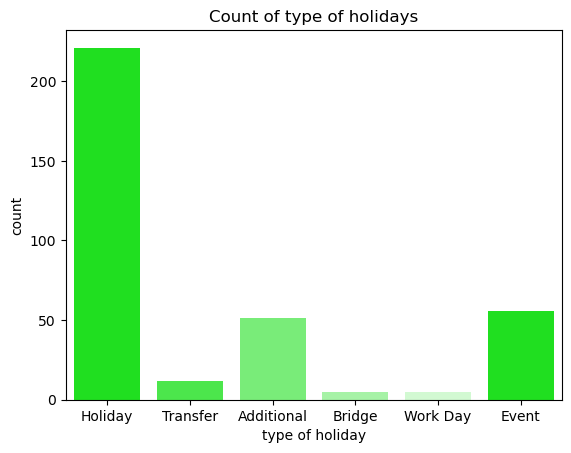

In [10]:
# to understand the frequency of holiday
holiday_df.set_index("date")
sns.countplot(x="type", data=holiday_df, palette=["#00FF00", "#33FF33", "#66FF66", "#99FF99", "#CCFFCC"])
plt.xlabel("type of holiday")
plt.title("Count of type of holidays")
plt.show()

<b> Checking the sales over the years

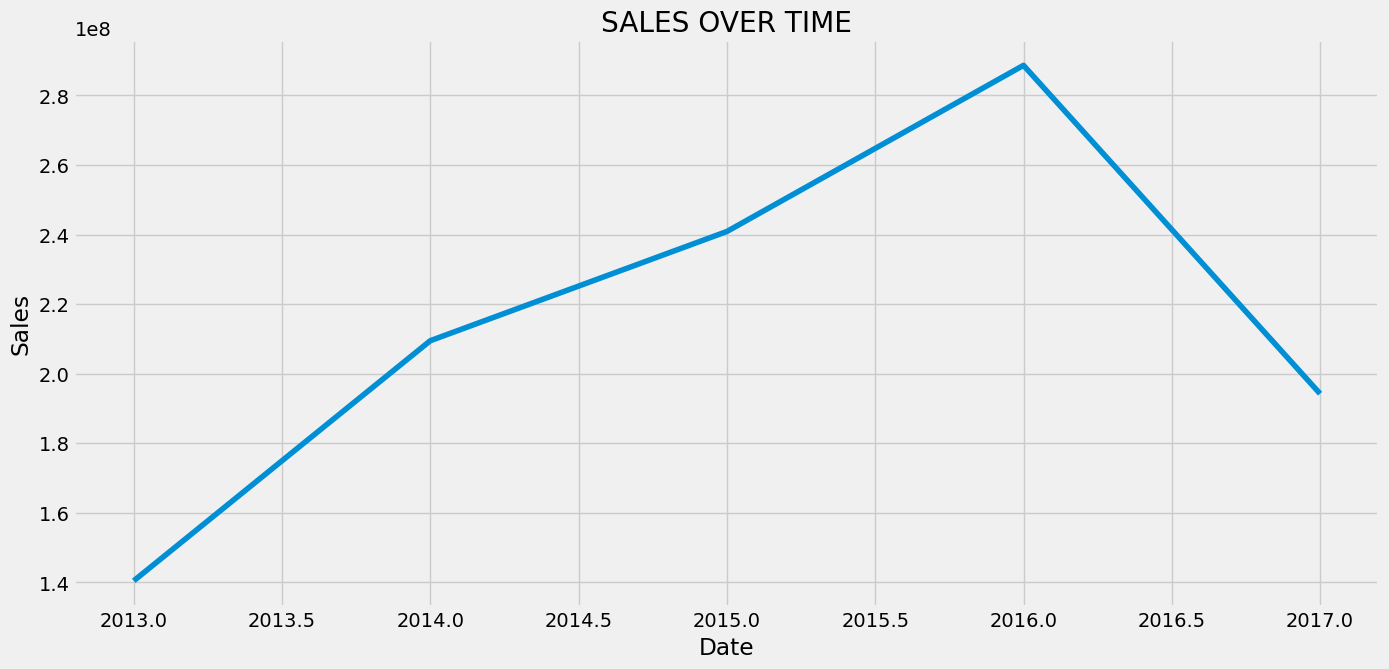

In [57]:
sales_time = train_data.groupby("year").sales.sum().reset_index()
sales_time = sales_time.set_index("year")
sales_time.plot(legend=False, figsize=(15, 7))

plt.title("SALES OVER TIME")
plt.ylabel("Sales")
plt.xlabel("Date")
plt.style.use("fivethirtyeight")
plt.show()

From our visualization there has been increase in the sales of product fro 2013 to first half of 2016 and sfter the sales started droping till 2017, which will still more analysis to understand the sudden drop in the sales

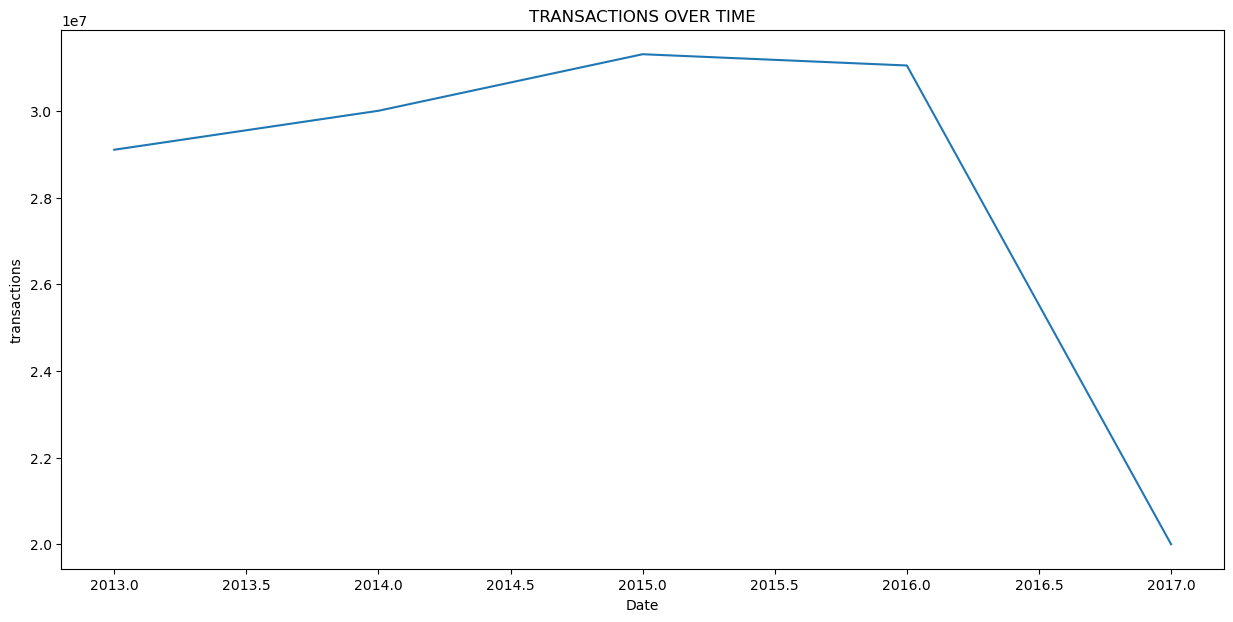

In [9]:
sales_time = transactions.groupby("year").transactions.sum().reset_index()
sales_time = sales_time.set_index("year")
sales_time.plot(legend=False, figsize=(15, 7))

plt.title("TRANSACTIONS OVER TIME")
plt.ylabel("transactions")
plt.xlabel("Date")
plt.style.use("fivethirtyeight")
plt.show()

From our visualization there has been increase in the sales of product fro 2013 to first half of 2016 and sfter the sales started droping till 2017, which will still more analysis to understand the sudden drop in the sales

# Identify regions with more or fewer holidays.

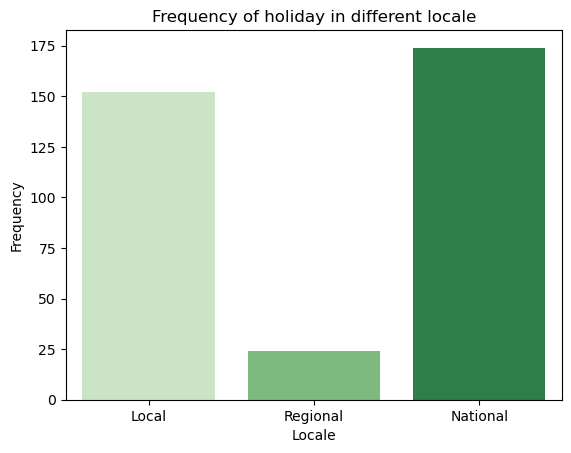

In [12]:
sns.countplot(x='locale', data=holiday_df, palette="Greens")
plt.title('Frequency of holiday in different locale')
plt.xlabel('Locale')
plt.ylabel("Frequency")
plt.show()

<b> Distribution of holiday in different months of the year

adding year and month on tableholiday_df


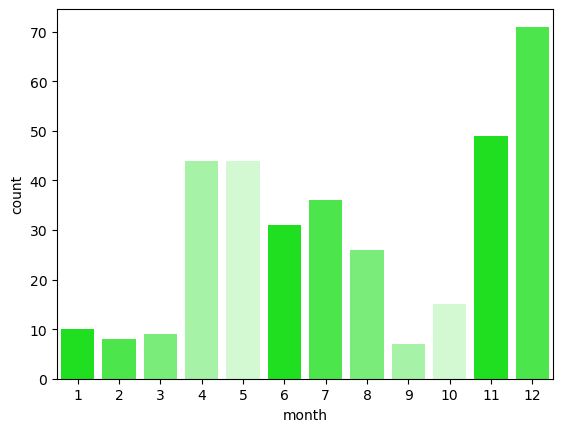

In [19]:
# Distribusion of holidays over different months of the year
add_year_month_(holiday_df,'holiday_df')
sns.countplot(x="month", data=holiday_df, palette= ["#00FF00", "#33FF33", "#66FF66", "#99FF99", "#CCFFCC"])
plt.show()

### sales of differentm products in different cluster

In [20]:
stores_clustter= stores_df.groupby('type')['cluster'].sum().reset_index()
stores_clustter= stores_clustter.sort_values(by='cluster', ascending=False)
stores_clustter

,type,cluster
3,D,123
2,C,122
0,A,111
1,B,62
4,E,40


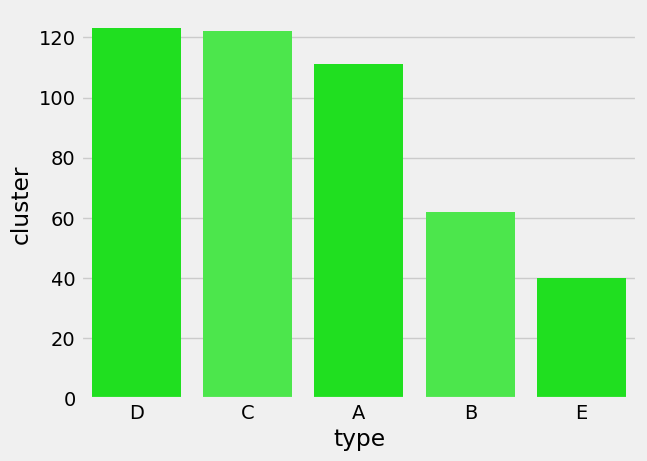

In [73]:
types = stores_df['type']

counts = ["types", "clusters"]
sns.barplot(x="type", y='cluster', data=stores_clustter, palette = ["#00FF00", "#33FF33"])


plt.show()

In [24]:
train_data

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [ ]:
holiday_df.set_index("date")
holiday_type = holiday_df.groupby("type")["date"]


<Figure size 1500x1000 with 0 Axes>

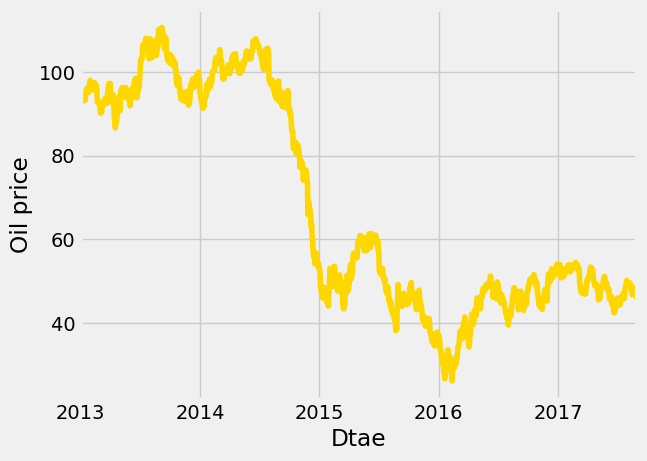

In [30]:
oil_df.set_index("date")
plt.figure(figsize=(15,10))
oil_df.plot(x="date", y="dcoilwtico", color="gold", legend=False)
plt.xlabel("Dtae")
plt.ylabel("Oil price")
plt.style.use("fivethirtyeight")
plt.show()

#  Using a pie chart to give an overview of how common it is for holidays to be transferred.

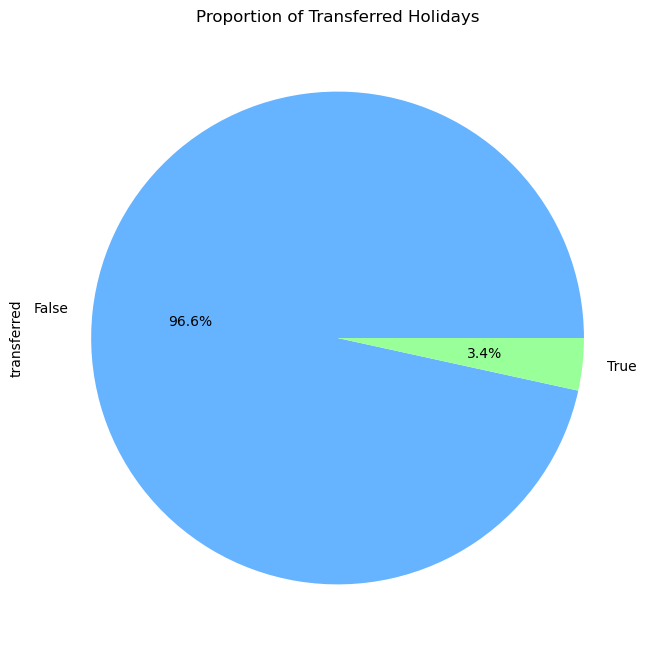

In [21]:
plt.figure(figsize=(8, 8))
holiday_df['transferred'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#66b3ff','#99ff99'])
plt.title('Proportion of Transferred Holidays')
plt.show()

In [26]:
train_data.set_index("date")
holiday_df.set_index('date')

,type,locale,locale_name,description,transferred,year,month
date,,,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,2012,3
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,2012,4
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,2012,4
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,2012,4
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,2012,4
...,...,...,...,...,...,...,...
2017-12-22,Additional,National,Ecuador,Navidad-3,False,2017,12
2017-12-23,Additional,National,Ecuador,Navidad-2,False,2017,12
2017-12-24,Additional,National,Ecuador,Navidad-1,False,2017,12


# Merge the data together for visualization

In [6]:
# Merging the common columns ('store_nbr' and 'date') in the datasets using the inner merge() function
# Merge train_df with stores_df based on 'store_nbr' column
merged_data1 = train_data.merge(stores_df, on='store_nbr', how='inner')

# Merge merged_df1 with transactions_df based on 'date' and 'store_nbr' columns
merged_data2 = merged_data1.merge(transactions, on=['date', 'store_nbr'], how='inner')

# # Merge merged_df2 with holidays_events_df based on 'date' column
# merged_data3 = merged_data2.merge(holiday_df, on='date', how='inner')

# Merge merged_df3 with oil_df based on 'date' column
merged_data = merged_data2.merge(oil_df, on='date', how='inner')

# View the first five rows of the merged dataset
merged_data.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,type_y,locale,locale_name,description,transferred,dcoilwtico
0,73062,2013-02-11,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,73063,2013-02-11,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,73064,2013-02-11,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,73065,2013-02-11,1,BEVERAGES,172.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,73066,2013-02-11,1,BOOKS,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


From the merged data above we notice that there are some columns that was renamed to type_x and type_y

In [11]:
# checking for the uniqueness of the column on the merged table
merged_data.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'year_x',
       'month_x', 'city', 'state', 'type_x', 'cluster', 'transactions',
       'year_y', 'month_y', 'type_y', 'locale', 'locale_name', 'description',
       'transferred', 'year_x', 'month_x', 'dcoilwtico', 'year_y', 'month_y'],
      dtype='object')

In [7]:
print('Unique data in type_x')
print(merged_data['type_x'].unique())
print()
print('Unique data in type_y')
print(merged_data['type_y'].unique())

Unique data in type_x
['D' 'C' 'B' 'E' 'A']

Unique data in type_y
['Holiday' 'Additional' 'Transfer' 'Event' 'Bridge']


In [8]:
# Renaming the type_x store_type and type_y to holiday_type
merged_data = merged_data.rename(columns={"type_x": "store_type", "type_y": "holiday_type"})
merged_data.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico
0,73062,2013-02-11,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,73063,2013-02-11,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,73064,2013-02-11,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,73065,2013-02-11,1,BEVERAGES,172.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,73066,2013-02-11,1,BOOKS,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


In [11]:
# setting the data cplumn as index
merged_data.set_index('date')

,id,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico
date,,,,,,,,,,,,,,,,
2013-02-11,73062,1,AUTOMOTIVE,0.00000,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2013-02-11,73063,1,BABY CARE,0.00000,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2013-02-11,73064,1,BEAUTY,0.00000,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2013-02-11,73065,1,BEVERAGES,172.00000,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2013-02-11,73066,1,BOOKS,0.00000,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-01,1297885,25,POULTRY,279.16998,0,Salinas,Santa Elena,D,1,2202,Holiday,National,Ecuador,Primer dia del ano,False,52.720001
2015-01-01,1297886,25,PREPARED FOODS,121.94100,0,Salinas,Santa Elena,D,1,2202,Holiday,National,Ecuador,Primer dia del ano,False,52.720001
2015-01-01,1297887,25,PRODUCE,105.00000,0,Salinas,Santa Elena,D,1,2202,Holiday,National,Ecuador,Primer dia del ano,False,52.720001


In [35]:
# checking the info of the merged data set
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322047 entries, 0 to 322046
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            322047 non-null  int64         
 1   date          322047 non-null  datetime64[ns]
 2   store_nbr     322047 non-null  int64         
 3   family        322047 non-null  object        
 4   sales         322047 non-null  float64       
 5   onpromotion   322047 non-null  int64         
 6   city          322047 non-null  object        
 7   state         322047 non-null  object        
 8   store_type    322047 non-null  object        
 9   cluster       322047 non-null  int64         
 10  transactions  322047 non-null  int64         
 11  holiday_type  322047 non-null  object        
 12  locale        322047 non-null  object        
 13  locale_name   322047 non-null  object        
 14  description   322047 non-null  object        
 15  transferred   322

In [36]:
#  cheking for duplicates
merged_data.duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
322042    False
322043    False
322044    False
322045    False
322046    False
Length: 322047, dtype: bool

In [37]:
#  checking for null values
merged_data.isna().sum()

id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
city            0
state           0
store_type      0
cluster         0
transactions    0
holiday_type    0
locale          0
locale_name     0
description     0
transferred     0
dcoilwtico      0
dtype: int64

In [40]:
# checking for the statistical summary of the data
print('statistical summary of the object column')
print(merged_data.describe(include=object).T)
print()

print('statistical summary of the numerical column')
print(merged_data.describe().T)

statistical summary of the object column


               count unique         top    freq
family        322047     33  AUTOMOTIVE    9759
city          322047     22       Quito  112266
state         322047     16   Pichincha  118668
store_type    322047      5           D  110121
holiday_type  322047      5     Holiday  202818
locale        322047      3    National  160710
locale_name   322047     24     Ecuador  160710
description   322047     80    Carnaval   16368

statistical summary of the numerical column
                 count          mean            std         min           25%  \
id            322047.0  1.682979e+06  786249.257767  561.000000  1.010616e+06   
store_nbr     322047.0  2.699467e+01      15.595174    1.000000  1.300000e+01   
sales         322047.0  4.063835e+02    1246.881240    0.000000  1.000000e+00   
onpromotion   322047.0  3.727136e+00      15.512095    0.000000  0.000000e+00   
cluster       322047.0  8.531202e+00       4.713809    1.000000  4.000000e+00   
transactions  322047.0  1.734118e+03 

#### Univariet Analysis

<b> Checking for seanality of sales of products over the years

<Figure size 1500x1000 with 0 Axes>

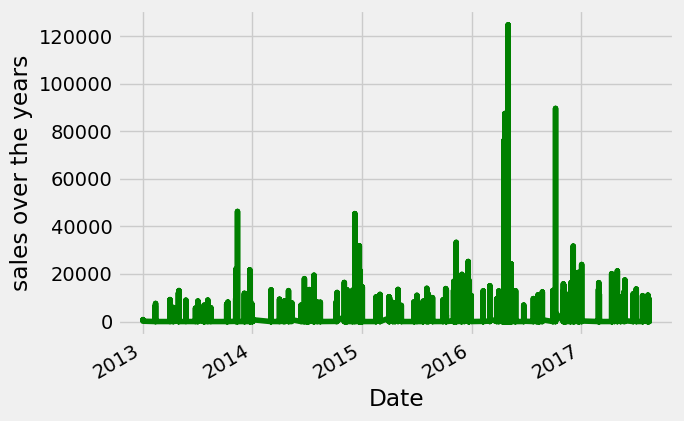

In [28]:
# Checking for seanality of sales of products over the years
# oil_df.set_index("date")
plt.figure(figsize=(15,10))
merged_data.plot(x="date", y="sales", color="green", legend=False)
plt.xlabel("Date")
plt.ylabel("sales over the years")
plt.style.use("fivethirtyeight")
plt.show()

From the visualization we can see there is seanality on the data set

<b>  1. Distribusion of sales over the years <b>

In [45]:
sales_frequency    = merged_data.groupby('year')['sales'].sum().reset_index()
sales_frequency = sales_frequency.sort_values(by='sales',ascending=False)
sales_frequency

,year,sales
3,2016,4.566470e+07
1,2014,2.809424e+07
2,2015,2.752824e+07
4,2017,1.792345e+07
0,2013,1.166394e+07


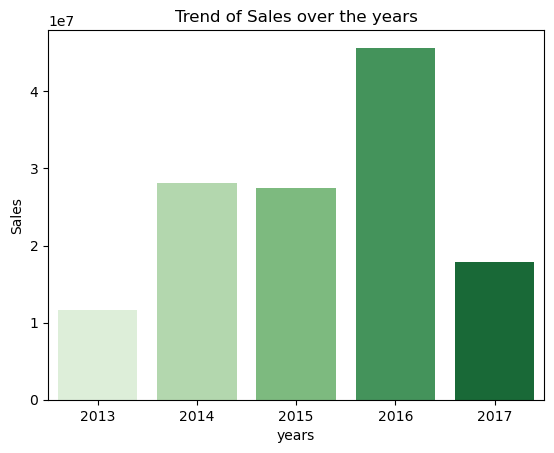

In [47]:
sns.barplot(x= 'year', y='sales', data= sales_frequency, palette="Greens")
plt.title('Distribution of Sales over the years')
plt.ylabel('Sales')
plt.xlabel('years')
plt.show()

In [ ]:
plt.figure(figsize=(15,10))
merged_data.hist()
plt.show()

# Bivarient

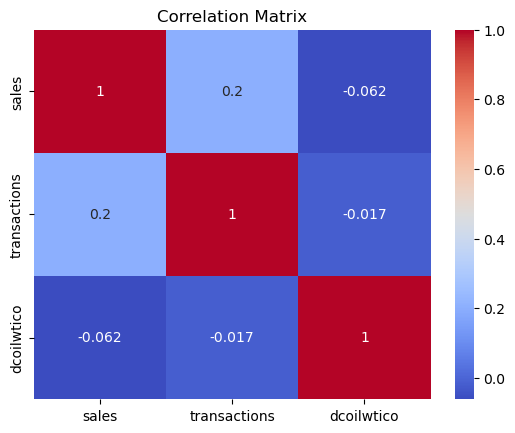

In [13]:
# Select numerical variables for correlation analysis
numerical_vars = ['sales', 'transactions', 'dcoilwtico']

# Compute correlation matrix
corr_matrix = merged_data[numerical_vars].corr()

# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Answering Questions and Hypotesis

##### 1. Is the train dataset complete (has all the required dates)?



In [14]:
# Check the completeness of the train dataset
min_date = train_data['date'].min()
max_date = train_data['date'].max()
expected_dates = pd.date_range(start=min_date, end=max_date)

missing_dates = expected_dates[~expected_dates.isin(train_data['date'])]

if len(missing_dates) == 0:
    print("The train dataset is complete. It includes all the required dates.")
else:
    print("The train dataset is incomplete. The following dates are missing:")
    print(missing_dates)

The train dataset is incomplete. The following dates are missing:
DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


From the above it is obvserverd that the dates in train data set is not complete some of the dates are missing which soposed to be christmas holidays that is 12-25 of every year

In [15]:
#  To complete the missing dates in the data set

# Complete the missing dates in the train dataset
# Create an index of the missing dates as a DatetimeIndex object
missing_dates = pd.Index(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]')

# Create a DataFrame with the missing dates, using the 'date' column
missing_data = pd.DataFrame({'date': missing_dates})

# Concatenate the original train dataset and the missing data DataFrame
# ignore_index=True ensures a new index is assigned to the resulting DataFrame
train_data = pd.concat([train_data, missing_data], ignore_index=True)

# Sort the DataFrame based on the 'date' column in ascending order
train_data.sort_values('date', inplace=True)


In [17]:
# Check the completeness of the train dataset
min_date = train_data['date'].min()
max_date = train_data['date'].max()
expected_dates = pd.date_range(start=min_date, end=max_date)

missing_dates = expected_dates[~expected_dates.isin(train_data['date'])]

if len(missing_dates) == 0:
    print("The train dataset is complete. It includes all the required dates.")
else:
    print("The train dataset is incomplete. The following dates are missing:")
    print(missing_dates)

The train dataset is complete. It includes all the required dates.


#### 2. Which dates have the lowest and highest sales for each year?

In [18]:

# Find the date with the lowest sales for each year
min_sales_dates = train_data.loc[train_data.groupby('year')['sales'].idxmin()][['year', 'date', 'month', 'sales']]

# Find the date with the highest sales for each year
max_sales_dates = train_data.loc[train_data.groupby('year')['sales'].idxmax()][['year', 'date', 'month', 'sales']]

print("Dates with the Lowest Sales for Each Year:")
print(min_sales_dates)

print("\nDates with the Highest Sales for Each Year:")
print(max_sales_dates)

Dates with the Lowest Sales for Each Year:
           year       date  month  sales
0        2013.0 2013-01-01    1.0    0.0
649832   2014.0 2014-01-01    1.0    0.0
1298484  2015.0 2015-01-01    1.0    0.0
1947132  2016.0 2016-01-01    1.0    0.0
2597563  2017.0 2017-01-01    1.0    0.0

Dates with the Highest Sales for Each Year:
           year       date  month       sales
562596   2013.0 2013-11-12   11.0   46271.000
1257246  2014.0 2014-12-08   12.0   45361.000
1916586  2015.0 2015-12-14   12.0   40351.460
2163723  2016.0 2016-05-02    5.0  124717.000
2760297  2017.0 2017-04-02    4.0   38422.625


## 4 Are certain groups of stores selling more products? (Cluster, city, state, type)

In [23]:
top_sales = merged_data.sort_values(by='sales', ascending=False)
top_10_sales= top_sales.head(20)

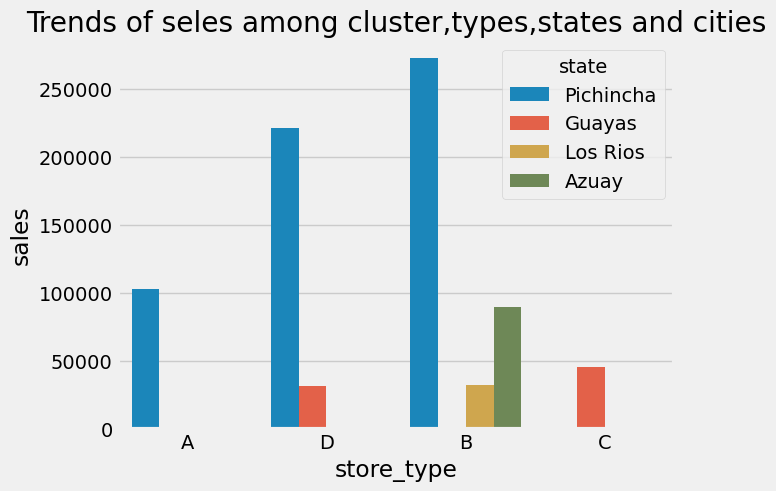

In [24]:
top_10_sales.set_index('date')

stores_sell_products = top_10_sales.groupby(["cluster", "city", "state", "store_type"])["sales"].sum().reset_index()
stores_sell_products = stores_sell_products.sort_values(by="sales")
sns.barplot(x='store_type', y='sales', hue='state', data=stores_sell_products, ci=None)
plt.title('Trends of seles among cluster,types,states and cities')
plt.show()

## 5 Are sales affected by promotions, oil prices and holidays?

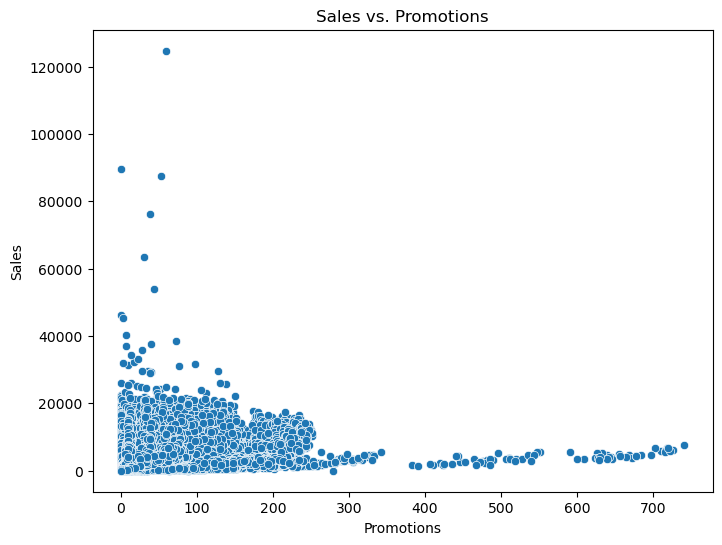

In [26]:
# Correlation analysis
correlation_promotions = train_data[['sales', 'onpromotion']].corr()

# Visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(x='onpromotion', y='sales', data=train_data)
plt.title('Sales vs. Promotions')
plt.xlabel('Promotions')
plt.ylabel('Sales')
plt.show()

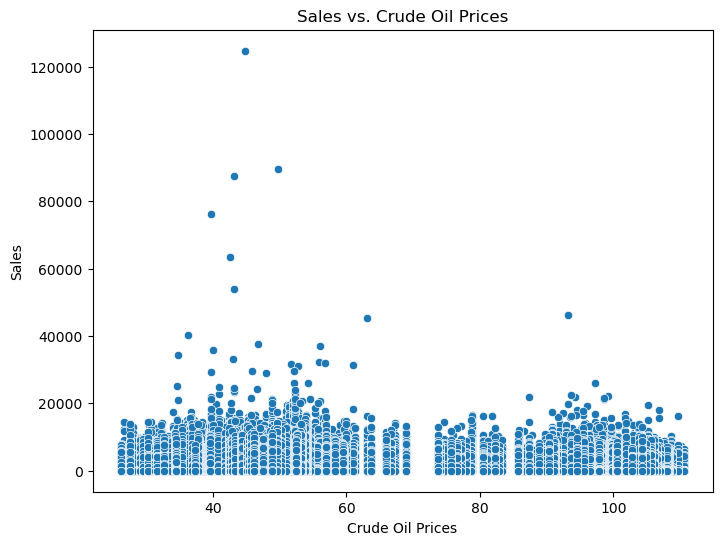

In [12]:


# Merge 'train' and 'oil' on 'date'
# merged_data = pd.merge(train_data, oil_df, on='date', how='left')

# Correlation analysis
correlation_oil_prices = merged_data[['sales', 'dcoilwtico']].corr()

# Visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(x='dcoilwtico', y='sales', data=merged_data)
plt.title('Sales vs. Crude Oil Prices')
plt.xlabel('Crude Oil Prices')
plt.ylabel('Sales')
plt.show()


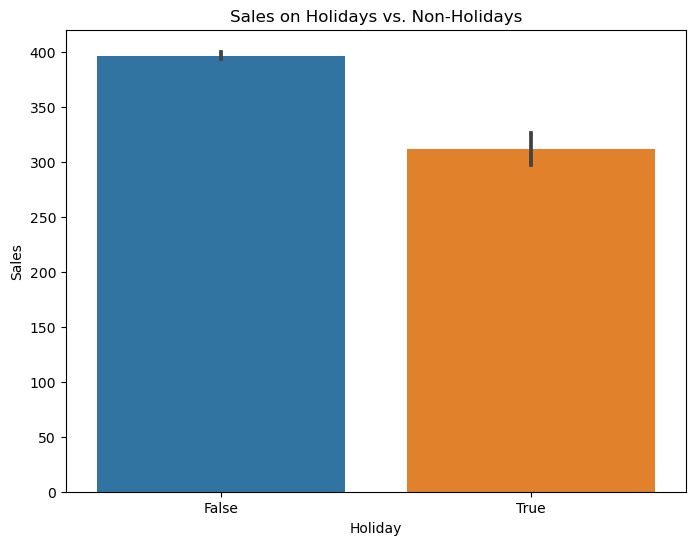

In [14]:



# Merge 'train' and 'holiday' on 'date'
# merged_data_holidays = pd.merge(train_data, holiday_df, on='date', how='left')

# Correlation analysis
correlation_holidays = merged_data[['sales', 'transferred']].corr()

# Visualization
plt.figure(figsize=(8, 6))
sns.barplot(x='transferred', y='sales', data=merged_data)
plt.title('Sales on Holidays vs. Non-Holidays')
plt.xlabel('Holiday')
plt.ylabel('Sales')
plt.show()

# Hypotesis Testing

In [21]:

null_hyp = 'the type of holiday does not have any significant on the increase of sales'
alt_hyp = 'the type of holiday has no significant on the increase of sales'
observed_value = pd.crosstab(merged_data['holiday_type'],merged_data['sales'])
chi2, p_value, dof, expected_value= stats.chi2_contingency(observed_value)
print('chi2:', chi2)
print('p_value:', p_value)
print('dof:', dof)
print('expected_value:',expected_value)
alpha=0.5
if p_value <= alpha:
    print('The null hypothesis is rejected')
    print(alt_hyp)
else:
    print('The nul hypothesis is accepted')
    print(null_hyp)

chi2: 240180.4731106544
p_value: 3.3176995310946164e-117
dof: 224428
expected_value: [[9.44960088e+03 1.28599242e-01 1.28599242e-01 ... 2.57198483e-01
  1.28599242e-01 1.28599242e-01]
 [1.11437524e+03 1.51654883e-02 1.51654883e-02 ... 3.03309765e-02
  1.51654883e-02 1.51654883e-02]
 [1.35155646e+04 1.83932780e-01 1.83932780e-01 ... 3.67865560e-01
  1.83932780e-01 1.83932780e-01]
 [4.62766908e+04 6.29777641e-01 6.29777641e-01 ... 1.25955528e+00
  6.29777641e-01 6.29777641e-01]
 [3.12476842e+03 4.25248489e-02 4.25248489e-02 ... 8.50496977e-02
  4.25248489e-02 4.25248489e-02]]
The null hypothesis is rejected
the type of holiday has no significant on the increase of sales


# Checking for sationality of the data

In [14]:
# # Statistical Test of the 'sales' column in the merged_df using Adfuller
# sales_data = merged_df['sales']

# # Perform ADF test
# result = adfuller(sales_data)

# # Extract the test statistics and p-value from the result
# test_statistic = result[0]
# p_value = result[1]
# critical_values = result[4]

# # Print the test statistics and critical values
# print(f"ADF Test Statistics: {test_statistic}")
# print(f"P-value: {p_value}")
# print("Critical Values:")
# for key, value in critical_values.items():
#     print(f"   {key}: {value}")

# # Check the p-value against a significance level (e.g., 0.05)
# if p_value <= 0.05:
#     print("Reject the null hypothesis: The sales data is stationary.")
# else:
#     print("Fail to reject the null hypothesis: The sales data is non-stationary.")


# Feature Enginering

## Train Dataset
<b>Extracting Date Components ( Month, Year and Day of The Week).


In [9]:
# defining a function to etract year and month from the data column
def add_year_month_(df,name):
    print(f'adding year and month on table {name:}')
    df['year']= df["date"].dt.year
    df['month']=df["date"].dt.month
    df['day'] =df['date'].dt.day
    

add_year_month_(merged_data, 'merged_data')

adding year and month on table merged_data


<b>Dropping Unneccessary Columns in The Merged and Test Datasets as it is not needed for our analysis

In [10]:
columns_to_drop = ['date', 'locale', 'locale_name', 'description', 'store_type', 'transferred', 'state']
merged_df_copy = merged_data.drop(columns=columns_to_drop)

merged_df_copy.head()

,id,store_nbr,family,sales,onpromotion,city,cluster,transactions,holiday_type,dcoilwtico,year,month,day
0,73062,1,AUTOMOTIVE,0.0,0,Quito,13,396,Holiday,97.010002,2013,2,11
1,73063,1,BABY CARE,0.0,0,Quito,13,396,Holiday,97.010002,2013,2,11
2,73064,1,BEAUTY,0.0,0,Quito,13,396,Holiday,97.010002,2013,2,11
3,73065,1,BEVERAGES,172.0,0,Quito,13,396,Holiday,97.010002,2013,2,11
4,73066,1,BOOKS,0.0,0,Quito,13,396,Holiday,97.010002,2013,2,11


# Feature Processing

In [11]:


# Define the categorical columns to encode
categorical_columns = ["family", "city", "holiday_type"]

# Perform one-hot encoding
encoder = OneHotEncoder()
one_hot_encoded_data = encoder.fit_transform(merged_df_copy[categorical_columns])

# Create column names for the one-hot encoded data
column_names = encoder.get_feature_names_out(categorical_columns)

# Convert the one-hot encoded data to a DataFrame
merged_df_encoded = pd.DataFrame(one_hot_encoded_data.toarray(), columns=column_names)

# Concatenate the original dataframe with the one-hot encoded data
merged_df_encoded = pd.concat([merged_df_copy, merged_df_encoded], axis=1)

# Drop the original categorical columns
merged_df_encoded.drop(categorical_columns, axis=1, inplace=True)

# Print the head of the encoded DataFrame
merged_df_encoded.head()

,id,store_nbr,sales,onpromotion,cluster,transactions,dcoilwtico,year,month,day,...,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo,holiday_type_Additional,holiday_type_Bridge,holiday_type_Event,holiday_type_Holiday,holiday_type_Transfer
0,73062,1,0.0,0,13,396,97.010002,2013,2,11,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,73063,1,0.0,0,13,396,97.010002,2013,2,11,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,73064,1,0.0,0,13,396,97.010002,2013,2,11,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,73065,1,172.0,0,13,396,97.010002,2013,2,11,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,73066,1,0.0,0,13,396,97.010002,2013,2,11,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Modelling

<b> seperating the train data and eval data

In [12]:
train_set=merged_df_encoded.loc[merged_df_encoded['year'].isin([2013,2014,2015,2016])]
eval_set=merged_df_encoded.loc[merged_df_encoded['year'] == 2017]

In [21]:
train_set.shape

(284889, 70)

In [22]:
eval_set.shape

(37158, 70)

In [13]:
# Separate the target variable and features for training and testing
X_train = train_set.drop('sales', axis=1)
y_train = train_set['sales'] 


X_eval = eval_set.drop('sales', axis=1)  
y_eval = eval_set['sales']

# Random Forest Regression

In [14]:
# Random Forest Regression Model
random_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_model.fit(X_train, y_train)
random_predictions = random_model.predict(X_eval)

# Calculate metrics
ramdom_mse = mean_squared_error(y_eval, random_predictions)
random_mae = mean_absolute_error(y_eval, random_predictions)

# Apply the absolute value function to both y_eval and rf_predictions
y_eval_abs = abs(y_eval)
random_predictions_abs = abs(random_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
random_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, random_predictions_abs))

# Create a DataFrame to store results for Random Forest
random_result = pd.DataFrame({'Model': ['Random Forest'],
                            'RMSLE': [random_rmsle],
                            'RMSE': [np.sqrt(random_mae )],
                            'MSE': [random_mae],
                            'MAE': [random_mae]}).round(2)

# Print the results_rf dataframe
random_result

ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

#  ARIMA MODEL

In [16]:
# ARIMA Model
# d and q are equal to zero as data is already stationary
p = 1
d = 0 
q = 0  

# Create an instance of the ARIMA model
arima_model = ARIMA(y_train, order=(p, d, q))
                    
# Fit the model to the training data
arima_model_fit = arima_model.fit()

# Make predictions on the evaluation data
arima_predictions = arima_model_fit.predict(start=len(y_train), end=len(y_train) + len(X_eval) - 1)

# Calculate evaluation metrics
arima_mse = mean_squared_error(y_eval, arima_predictions)
arima_rmse = np.sqrt(arima_mse)

# Apply the absolute value function to y_eval to remove negative signs
y_eval_abs = abs(y_eval)
arima_predictions_abs = abs(arima_predictions)

# Calculate the Mean Absolute Error (MAE)
arima_mae = mean_absolute_error(y_eval, arima_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
arima_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, arima_predictions_abs))

# Create a DataFrame to store results for ARIMA
results_arima = pd.DataFrame({'Model': ['ARIMA'],
                            'RMSLE': [arima_rmsle],
                            'RMSE': [np.sqrt(arima_mse)],
                            'MSE': [arima_mse],
                            'MAE': [arima_mae]}).round(2)

# Print the results_arima dataframe
results_arima

,Model,RMSLE,RMSE,MSE,MAE
0,ARIMA,3.44,1358.37,1845156.98,618.57


In [ ]:
# Initialize the results dataframe
model_df = pd.DataFrame(columns=['Model', 'RMSLE', 'RMSE', 'MSE', 'MAE'])

In [4]:
# from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
# pacf = plot_pacf(train_data['sales'], lags =10)
# acf = plot_acf(train_data['sales'], lags =10)